### Deep Convolutional GANs

In this notebook, you're going to create a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored in 2016 and has seen impressive results in generating new images; you can read the [original paper, here](https://arxiv.org/pdf/1511.06434.pdf).

### DCGAN Generator and Discriminator

Your first task will be to build the generator and discriminator networks. 

The Generator is made of a series of transpose convolutional layers, where you typically [batch normalize](https://arxiv.org/pdf/1502.03167.pdf) and then apply an [activation function](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) after each, except for the last layer where you typically apply a [tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh) or in this case a [sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid) activation. The output should be a $sigmoid$ activated matrix of the same shape as the `input_image` to the discriminator, i.e. $28\times28\times1$ since we want to generate grayscale images where each pixel value ranges from 0 to 1.

In [21]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        kernel_size = 5
        self.blocks = nn.ModuleList()
        self.fc = nn.Linear(latent_dim, 7 * 7 * 128)
        self.block1 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 128, kernel_size, stride=2, padding=2, output_padding=1),
        )
        self.block2 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size, stride=2, padding=2, output_padding=1),
        )
        self.block3 = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size, stride=1, padding=2),
        )
        self.block4 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size, stride=1, padding=2),
            nn.Sigmoid()
        )
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 128, 7, 7)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        img = self.block4(x)
        return img



### The Discriminator

The discriminator network is a series of [convolutional](https://pytorch.org/docs/stable/nn.html#convolution-layers) layers, where you typically [normalize](https://pytorch.org/docs/stable/nn.html#normalization-layers) and then apply a [Leaky ReLu](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU) activation. The number of output nodes, is equal to 1, which makes sense if you think about it. We want the discriminator to look at an image and output the probability that the image is real or not, i.e. a single scalar value that tells us whether or not the image is real.

In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        kernel_size = 5
        layer_filters = [32, 64, 128, 256]
        self.block1 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(1, layer_filters[0], kernel_size, stride=2, padding=2),
        )
        self.block2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(layer_filters[0], layer_filters[1], kernel_size, stride=2, padding=2),
        )
        self.block3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(layer_filters[1], layer_filters[2], kernel_size, stride=2, padding=2),
        )
        self.block4 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(layer_filters[2], layer_filters[3], kernel_size, stride=1, padding=2),     
        )
        self.fc = nn.Linear(4 * 4 * layer_filters[3], 1)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

### The Adversarial Network

This network is simply the generator and discriminator networks chained together to create a GAN. The input to the generator, $z$, will be a latent vector that is used to seed the generator, and will be passed to the discriminator, which will ultimately classify the generated image as real or not.

In [23]:
class Adversarial(nn.Module):
    def __init__(self, generator, discriminator):
        super(Adversarial, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def forward(self, z):
        img = self.generator(z)
        validity = self.discriminator(img)
        return validity

### Dataloaders

Using MNIST dataset to train the adversarial networks. Each training batch will contain images with shape $28\times28\times1$. We will not use the test dataset since we will train a generative model. You may wish to combine it with the train dataset.

In [24]:
import torch
import torchvision
from torchvision import transforms

# Define the transformation to apply to the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='~/data', train=True, transform=transform, download=True)
#test_dataset = torchvision.datasets.MNIST(root='~/data', train=False, transform=transform, download=True)

# Create dataloaders for training and testing
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Plotting Generated Images

After each epoch, we'll generate and plot some generated images. These images should start off looking like random noise, and then become more recognizable as the network is trained.

In [25]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def save_generated_images(generator, device, epoch=1):
    # Generate random noise vectors
    noise = torch.randn(16, 100).to(device)
    
    # Generate images using the generator
    with torch.no_grad():
        generated_images = generator(noise).detach().cpu()
    
    # Create a grid of 4 x 4 images
    grid = vutils.make_grid(generated_images, nrow=4, padding=2, normalize=True)
    
    # Save the grid of images
    filename = 'gan_ep-%s.png' % (epoch)
    vutils.save_image(grid, filename)


### GAN Training

After defining the network architectures and dataloader, you can finally train the GAN. The way to train a GAN is by training the discriminator and adversarial networks in an alternating fashion, where we first update the discriminator a set number of times, then update the adversarial network. 

During training of the discriminator, the generator's parameters are frozen, and vice versa when training the generator. The learning rate for training the discriminator is twice the learning rate of the generator. We want the discriminator to learn but at the same time we don't want it to be completely accurate in its prediction to give chance for the generator to learn and improve.

In [26]:
def train(generator, discriminator, 
          adversarial, trainloader,
          epochs=50):
    generator.train()
    discriminator.train()
    criterion = nn.BCELoss()
    lr = 2e-4
    decay = 6e-8
    factor = 0.5
    optimizer_g = torch.optim.RMSprop(generator.parameters(), 
                                    lr=lr*factor, weight_decay=decay*factor)    
    optimizer_d = torch.optim.RMSprop(discriminator.parameters(),
                                    lr=lr, weight_decay=decay) 
    # lr scheduler is not needed but you can try it
    #scheduler_g = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_g, T_max=epochs)
    #scheduler_d = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_d, T_max=epochs)
    
    for epoch in range(epochs):
        for i, (real_imgs, _) in enumerate(trainloader):
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.shape[0]
            real_labels = torch.ones(batch_size, 1, requires_grad=False).to(device)
            fake_labels = torch.zeros(batch_size, 1, requires_grad=False).to(device)
            z = torch.randn(batch_size, 100).to(device)
            
            # Train discriminator
            optimizer_d.zero_grad()
            generator.eval()
            with torch.no_grad():
                fake_imgs = generator(z)
        
            real_out = discriminator(real_imgs)
            fake_out = discriminator(fake_imgs)
            loss_real = criterion(real_out, real_labels)
            loss_fake = criterion(fake_out, fake_labels)
            loss_d = loss_real + loss_fake
            loss_d.backward()
            optimizer_d.step()
            
            # Train generator
            optimizer_g.zero_grad()
            generator.train()
            z = torch.randn(batch_size, 100, requires_grad=False).to(device)
            
            fake_out = adversarial(z)
            loss_g = criterion(fake_out, real_labels)
            loss_g.backward()
            optimizer_g.step()
            if i % 100 == 0:
                print('Epoch: %d, Iter: %d, Loss D: %.6f, Loss G: %.6f' % (epoch, i, loss_d.item(), loss_g.item()))
        #scheduler_g.step()
        #scheduler_d.step()
        print('Learning Rate (Generator):', optimizer_g.param_groups[0]['lr'])
        print('Learning Rate (Discriminator):', optimizer_d.param_groups[0]['lr'])
        save_generated_images(generator, device, epoch=epoch)


### Training the GAN

We instantiate a generator, a discriminator and an adversarial network. Finally, we train the GAN.

In [27]:
generator = Generator(100).to(device)
discriminator = Discriminator().to(device)
adversarial = Adversarial(generator, discriminator).to(device)
batch_size = 64
epochs = 50
train(generator, discriminator, adversarial, 
      train_dataloader, epochs=epochs)


Epoch: 0, Iter: 0, Loss D: 1.388577, Loss G: 0.999602


Epoch: 0, Iter: 100, Loss D: 0.593850, Loss G: 1.532923
Epoch: 0, Iter: 200, Loss D: 1.049684, Loss G: 0.389821
Epoch: 0, Iter: 300, Loss D: 1.161914, Loss G: 0.913161
Epoch: 0, Iter: 400, Loss D: 1.159736, Loss G: 0.907335
Epoch: 0, Iter: 500, Loss D: 0.994731, Loss G: 1.025943
Epoch: 0, Iter: 600, Loss D: 1.085476, Loss G: 0.873054
Epoch: 0, Iter: 700, Loss D: 1.287905, Loss G: 0.672095
Epoch: 0, Iter: 800, Loss D: 0.874986, Loss G: 1.268867
Epoch: 0, Iter: 900, Loss D: 1.124874, Loss G: 0.866482
Learning Rate (Generator): 0.0001
Learning Rate (Discriminator): 0.0002
Epoch: 1, Iter: 0, Loss D: 0.886704, Loss G: 1.287068
Epoch: 1, Iter: 100, Loss D: 1.164963, Loss G: 0.741889
Epoch: 1, Iter: 200, Loss D: 0.859661, Loss G: 1.492760
Epoch: 1, Iter: 300, Loss D: 0.844474, Loss G: 1.875231
Epoch: 1, Iter: 400, Loss D: 1.155619, Loss G: 1.089379
Epoch: 1, Iter: 500, Loss D: 1.018634, Loss G: 1.127913
Epoch: 1, Iter: 600, Loss D: 0.876486, Loss G: 1.248156
Epoch: 1, Iter: 700, Loss D: 1.009

## Generate an Animated GIF 

To see the evolution of the generated samples, we will generate an animated gif of all the images saved during training.

Install     imageio first:

`pip install imageio`

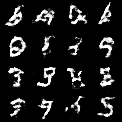

KeyboardInterrupt: 

In [32]:
import imageio
import time
from IPython.display import Image
from IPython.display import display
from IPython.display import clear_output

# List of PNG image filenames
image_filenames = [f"gan_ep-{i}.png" for i in range(epochs)]

# Read the PNG images and append them to a list
images = []
for filename in image_filenames:
    image = imageio.imread(filename)
    images.append(image)

# Save the list of images as a GIF
output_filename = 'dcgan_anim.gif'
imageio.mimsave(output_filename, images, duration=0.5)

# Display the GIF
while True:
    clear_output(wait=True)
    display(Image(filename=output_filename))
    time.sleep(2)
